In [178]:
from locale import currency

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import polars as pl
import polars.selectors as cs
import numpy as np
import plotly.express as px

In [179]:
# read in the data MNIST data
raw_df = pl.read_csv('mnist_train_small.csv')


# if using colab
# raw_df = pl.read_csv('/content/sample_data/mnist_train_small.csv')



In [180]:
raw_df.head()

6,0,0_duplicated_0,0_duplicated_1,0_duplicated_2,0_duplicated_3,0_duplicated_4,0_duplicated_5,0_duplicated_6,0_duplicated_7,0_duplicated_8,0_duplicated_9,0_duplicated_10,0_duplicated_11,0_duplicated_12,0_duplicated_13,0_duplicated_14,0_duplicated_15,0_duplicated_16,0_duplicated_17,0_duplicated_18,0_duplicated_19,0_duplicated_20,0_duplicated_21,0_duplicated_22,0_duplicated_23,0_duplicated_24,0_duplicated_25,0_duplicated_26,0_duplicated_27,0_duplicated_28,0_duplicated_29,0_duplicated_30,0_duplicated_31,0_duplicated_32,0_duplicated_33,0_duplicated_34,…,0_duplicated_553,0_duplicated_554,0_duplicated_555,0_duplicated_556,0_duplicated_557,0_duplicated_558,0_duplicated_559,0_duplicated_560,0_duplicated_561,0_duplicated_562,0_duplicated_563,0_duplicated_564,0_duplicated_565,0_duplicated_566,0_duplicated_567,0_duplicated_568,0_duplicated_569,0_duplicated_570,0_duplicated_571,0_duplicated_572,0_duplicated_573,0_duplicated_574,0_duplicated_575,0_duplicated_576,0_duplicated_577,0_duplicated_578,0_duplicated_579,0_duplicated_580,0_duplicated_581,0_duplicated_582,0_duplicated_583,0_duplicated_584,0_duplicated_585,0_duplicated_586,0_duplicated_587,0_duplicated_588,0_duplicated_589
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [181]:
# select the data
labels = raw_df[:, 0]
data = raw_df[:, 1:]

In [182]:
# conver to tensor data
dataT = torch.tensor(data.to_numpy()).float()
labelsT = torch.tensor(labels.to_numpy()).long()

In [183]:
# split the data for training
X_train, X_test, y_train, y_test = train_test_split(dataT, labelsT, test_size=0.3, random_state=42)

In [184]:
# transform the data using FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# case 1 train 0, 1 with test 0, 255
X_train_norm_case1 = FunctionTransformer(lambda x: x / torch.max(X_train), validate=True)
X_test_norm_case1 = FunctionTransformer(lambda x: (x / torch.max(X_test)) * 255, validate=True)


# fit and transform the norm
X_train_transformed_01= X_train_norm_case1.fit_transform(X_train)
X_test_transformed_01 = X_test_norm_case1.fit_transform(X_test)

# create dataset
train_dataset_case1 =TensorDataset(X_train_transformed_01, y_train)
test_dataset_case1 = TensorDataset(X_test_transformed_01, y_test)

# create dataloader
batchSize = 32
train_loader_case1 = DataLoader(train_dataset_case1, batch_size=batchSize, shuffle=True, drop_last=True)
test_loader_case1 = DataLoader(test_dataset_case1, batch_size=test_dataset_case1.tensors[0].shape[0])

In [185]:
# test the normalization
# max should be 1
print(torch.tensor(X_train_transformed_01).float().max())

# max should be 255 for the test
print(torch.tensor(X_test_transformed_01).float().max())

tensor(1.)
tensor(255.)


/var/folders/f8/vcqysvdd39j1b3z4bt0ttjt40000gn/T/ipykernel_24968/3595036055.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(X_train_transformed_01).float().max())
/var/folders/f8/vcqysvdd39j1b3z4bt0ttjt40000gn/T/ipykernel_24968/3595036055.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(X_test_transformed_01).float().max())


In [186]:
# case 2: Train 0, 255; Test 0, 1
X_train_norm_case2 = FunctionTransformer(lambda x: (x / torch.max(X_train)) * 255, validate=True)
X_test_norm_case2 = FunctionTransformer(lambda x: (x / torch.max(X_test)), validate=True)

# fit and tranform the data
X_train_transformed_02 = X_train_norm_case2.fit_transform(X_train)
X_test_transformed_02 = X_test_norm_case2.fit_transform(X_test)

# crate dataset
train_dataset_case2 = TensorDataset(X_train_transformed_02, y_train)
test_dataset_case2 = TensorDataset(X_test_transformed_02, y_test)

# create dataloader
batchSize = 32
train_loader_case2 = DataLoader(train_dataset_case2, batch_size=batchSize, shuffle=True, drop_last=True)
test_loader_case2 = DataLoader(test_dataset_case2, batch_size=test_dataset_case2.tensors[0].shape[0])

In [187]:
# case 3: Train 0, 1; Test 0, 1
X_train_norm_case3 = FunctionTransformer(lambda x: (x / torch.max(X_train)), validate=True)
X_test_norm_case3 = FunctionTransformer(lambda x: (x / torch.max(X_test)), validate=True)

# fit and tranform the data
X_train_transformed_03 = X_train_norm_case3.fit_transform(X_train)
X_test_transformed_03 = X_test_norm_case3.fit_transform(X_test)

# crate dataset
train_dataset_case3 = TensorDataset(X_train_transformed_03, y_train)
test_dataset_case3 = TensorDataset(X_test_transformed_03, y_test)

# create dataloader
batchSize = 32
train_loader_case3 = DataLoader(train_dataset_case3, batch_size=batchSize, shuffle=True, drop_last=True)
test_loader_case3 = DataLoader(test_dataset_case3, batch_size=test_dataset_case3.tensors[0].shape[0])

In [188]:
# test the normalization
# max should be 1
print(torch.tensor(X_train_transformed_02).float().max())

# max should be 255 for the test
print(torch.tensor(X_test_transformed_02).float().max())

tensor(255.)
tensor(1.)


/var/folders/f8/vcqysvdd39j1b3z4bt0ttjt40000gn/T/ipykernel_24968/2740165416.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(X_train_transformed_02).float().max())
/var/folders/f8/vcqysvdd39j1b3z4bt0ttjt40000gn/T/ipykernel_24968/2740165416.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(X_test_transformed_02).float().max())


In [189]:
# define a class
class ANN(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(784, 64)
        self.hidden1 = nn.Linear(64, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu( self.input(x) )
        x = F.relu( self.hidden1(x) )
        x = F.relu( self.hidden2(x) )

        return torch.log_softmax(self.output(x), axis=1)


In [190]:
# create model componenets
def createANNnet(learningRate=0.01, epochStep=10, gamma=1/2):
    model = ANN()
    lossfunc = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

    step_size = len(train_loader) * epochStep
    schedular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    return model, lossfunc, optimizer, schedular

In [191]:
# train the model
def trainModel(train_loader, test_loader, numepochs=100, toggleDynamic=True):
    # define an empty list
    training_progress = pl.DataFrame(
        schema=[
            ('iteration', pl.Int64),
            ('epoch', pl.Int64),
            ('train_loss', pl.Float64),
            ('train_acc', pl.Float64),
            ('test_loss', pl.Float64),
            ('test_acc', pl.Float64),
            ('learning_rate', pl.Float64)
        ]
    )
    iteration = 0

    # create the ann Model
    model, lossfunc, optimizer, schedular = createANNnet(learningRate=0.01, epochStep=10, gamma=1/2)

    # get test data once (since we are using a test_loader that loads all data at once)
    X_testTL, y_testTL = next(iter(test_loader))

    # training looop
    for epoch in range(numepochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_acc = 0
        num_batches = 0

        # iterate through the training batches
        for X_trainTL, y_trainTL in train_loader:
            yhat_train = model(X_trainTL)
            train_loss = lossfunc(yhat_train, y_trainTL)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if toggleDynamic:
                schedular.step()
                current_lrs = schedular.get_last_lr()[0]
            else:
                current_lrs = optimizer.param_groups[0]['lr']

            # get accuracy
            train_matches = (torch.argmax(yhat_train, axis=1) == y_trainTL).float()
            train_acc = 100 * torch.mean(train_matches)

            # number of batches - a counter for how many batches were processed in this epoch
            # epoch_train_loss = this is a running of the total of the trainin gloss for all the batches in the current epoch
            # epoch_train_loss / num_batches  computes the average t raining loss per batch during the epoch
            epoch_train_loss += train_loss.item()
            epoch_train_acc += train_acc.item()

            num_batches += 1

        # end of epoch: evaluate test Once
        model.eval()
        with torch.no_grad():
            yhat_test = model(X_testTL)
            test_loss = lossfunc(yhat_test, y_testTL)
            test_matches = (torch.argmax(yhat_test, axis=1) ==y_testTL).float()
            test_acc = 100 * torch.mean(test_matches)

        # log single row per epoch
        new_row = pl.DataFrame([{
            'iteration':iteration,
            'epoch':epoch,
            'train_loss': epoch_train_loss / num_batches,
            'train_acc' : epoch_train_acc / num_batches,
            'test_loss' : test_loss.item(),
            'test_acc' : test_acc.item(),
            'learning_rate' : current_lrs
        }])

        # add row to the dataframe
        training_progress = pl.concat([training_progress, new_row])
        iteration += 1

        # this matches withe the epoch step
        if epoch % 10 == 0 or epoch == numepochs -1 :
            print(
                f"Epoch {epoch+1}/{numepochs} - "
                f"Training: Loss={epoch_train_loss / num_batches:.4f}, "
                f"Accuracy={epoch_train_acc / num_batches:.2f}% | "
                f"Testing: Loss={test_loss.item():.4f}, "
                f"Accuracy={test_acc.item():.2f}% | "
                f"Learning Rate: {current_lrs:.6f}"
            )
    return training_progress, model

In [192]:
# train the model for test case 1
# case 1 train 0, 1 with test 0, 255
training_progress_case1, model_case1 = trainModel(train_loader_case1, test_loader_case1, numepochs=60, toggleDynamic=True)

Epoch 1/60 - Training: Loss=0.4688, Accuracy=85.23% | Testing: Loss=61.9680, Accuracy=90.32% | Learning Rate: 0.010000
Epoch 11/60 - Training: Loss=0.0490, Accuracy=98.62% | Testing: Loss=58.0784, Accuracy=94.52% | Learning Rate: 0.005000
Epoch 21/60 - Training: Loss=0.0114, Accuracy=99.69% | Testing: Loss=73.3864, Accuracy=95.52% | Learning Rate: 0.002500
Epoch 31/60 - Training: Loss=0.0018, Accuracy=99.94% | Testing: Loss=103.5430, Accuracy=95.88% | Learning Rate: 0.001250
Epoch 41/60 - Training: Loss=0.0003, Accuracy=99.99% | Testing: Loss=123.2712, Accuracy=95.78% | Learning Rate: 0.000625
Epoch 51/60 - Training: Loss=0.0001, Accuracy=100.00% | Testing: Loss=144.8969, Accuracy=95.87% | Learning Rate: 0.000313
Epoch 60/60 - Training: Loss=0.0000, Accuracy=100.00% | Testing: Loss=160.8086, Accuracy=95.88% | Learning Rate: 0.000156


In [193]:
# train the model for test case 2
# case 2: Train 0, 255; Test 0, 1
training_progress_case2, model_case2 = trainModel(train_loader_case2, test_loader_case2, numepochs=60, toggleDynamic=True)

Epoch 1/60 - Training: Loss=0.9403, Accuracy=72.26% | Testing: Loss=2.2846, Accuracy=15.18% | Learning Rate: 0.010000
Epoch 11/60 - Training: Loss=0.6620, Accuracy=77.97% | Testing: Loss=2.1588, Accuracy=23.82% | Learning Rate: 0.005000
Epoch 21/60 - Training: Loss=0.3613, Accuracy=90.80% | Testing: Loss=2.5366, Accuracy=27.43% | Learning Rate: 0.002500
Epoch 31/60 - Training: Loss=0.2541, Accuracy=93.42% | Testing: Loss=2.6031, Accuracy=27.25% | Learning Rate: 0.001250
Epoch 41/60 - Training: Loss=0.2016, Accuracy=95.02% | Testing: Loss=2.7279, Accuracy=28.63% | Learning Rate: 0.000625
Epoch 51/60 - Training: Loss=0.1816, Accuracy=95.48% | Testing: Loss=2.7952, Accuracy=28.60% | Learning Rate: 0.000313
Epoch 60/60 - Training: Loss=0.1687, Accuracy=95.78% | Testing: Loss=2.8807, Accuracy=28.65% | Learning Rate: 0.000156


In [194]:
# train the model for test case 3
# case 2: Train 0, 1; Test 0, 1
training_progress_case3, model_case3 = trainModel(train_loader_case3, test_loader_case3, numepochs=60, toggleDynamic=True)

Epoch 1/60 - Training: Loss=0.4802, Accuracy=85.06% | Testing: Loss=0.2728, Accuracy=92.18% | Learning Rate: 0.010000
Epoch 11/60 - Training: Loss=0.0565, Accuracy=98.41% | Testing: Loss=0.2035, Accuracy=95.65% | Learning Rate: 0.005000
Epoch 21/60 - Training: Loss=0.0120, Accuracy=99.61% | Testing: Loss=0.3013, Accuracy=96.07% | Learning Rate: 0.002500
Epoch 31/60 - Training: Loss=0.0024, Accuracy=99.93% | Testing: Loss=0.4056, Accuracy=96.20% | Learning Rate: 0.001250
Epoch 41/60 - Training: Loss=0.0002, Accuracy=100.00% | Testing: Loss=0.4823, Accuracy=96.10% | Learning Rate: 0.000625
Epoch 51/60 - Training: Loss=0.0001, Accuracy=100.00% | Testing: Loss=0.5382, Accuracy=96.07% | Learning Rate: 0.000313
Epoch 60/60 - Training: Loss=0.0000, Accuracy=100.00% | Testing: Loss=0.5912, Accuracy=95.98% | Learning Rate: 0.000156


In [195]:
# create new columns for each dataframe and concat them together
training_progress_case1 = (
    training_progress_case1
    .with_columns(
        test_case=pl.lit('test_case1')
    )
)

training_progress_case2 = (
    training_progress_case2
    .with_columns(
        test_case=pl.lit('test_case2')
    )
)

training_progress_case3 = (
    training_progress_case3
    .with_columns(
        test_case=pl.lit('test_case3')
    )
)
final_training_progress = pl.concat([training_progress_case1, training_progress_case2, training_progress_case3])

In [196]:
# groupby analysis
group_epoch_performance_metrics = (
    final_training_progress
    .group_by('test_case','epoch')
    .agg(
        cs.numeric().mean().name.prefix('mean_')
    )
    .sort('epoch', descending=False)
)

In [197]:
group_epoch_performance_metrics.head()

test_case,epoch,mean_iteration,mean_train_loss,mean_train_acc,mean_test_loss,mean_test_acc,mean_learning_rate
str,i64,f64,f64,f64,f64,f64,f64
"""test_case3""",0,0.0,0.480189,85.061499,0.272836,92.183334,0.01
"""test_case2""",0,0.0,0.940335,72.261156,2.28459,15.183334,0.01
"""test_case1""",0,0.0,0.468791,85.233124,61.968033,90.316666,0.01
"""test_case1""",1,1.0,0.254907,92.57008,39.369793,93.266663,0.01
"""test_case2""",1,1.0,0.543821,85.326087,2.26256,14.849999,0.01


Text(0, 0.5, 'Model Accuracy')

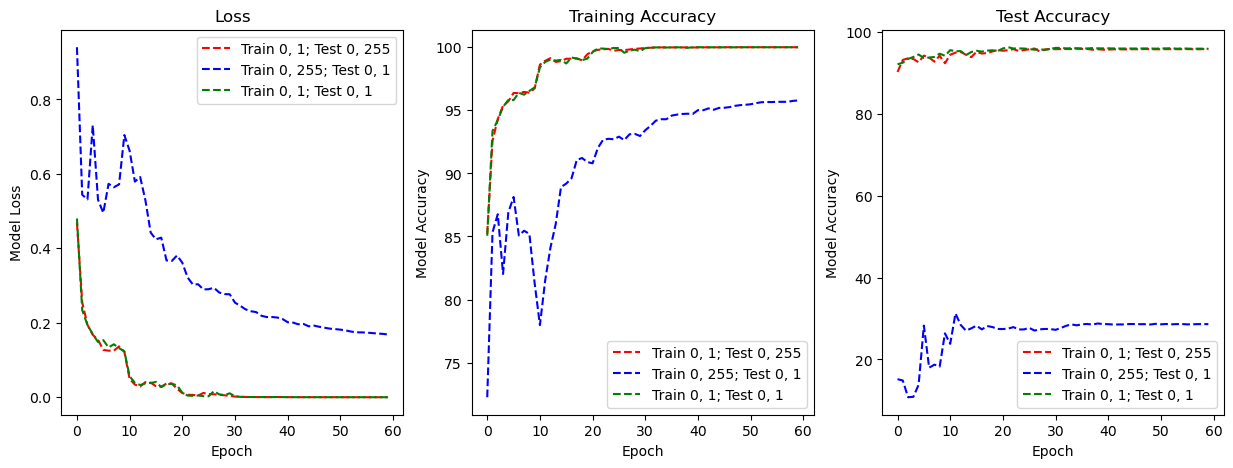

In [198]:
# inspect the loss
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].plot(group_epoch_performance_metrics.filter(pl.col('test_case').eq('test_case1')).select('mean_train_loss'), 'r--')
ax[0].plot(group_epoch_performance_metrics.filter(pl.col('test_case').eq('test_case2')).select('mean_train_loss'), 'b--')
ax[0].plot(group_epoch_performance_metrics.filter(pl.col('test_case').eq('test_case3')).select('mean_train_loss'), 'g--')
ax[0].legend(['Train 0, 1; Test 0, 255', 'Train 0, 255; Test 0, 1', 'Train 0, 1; Test 0, 1'])
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Model Loss')

ax[1].plot(group_epoch_performance_metrics.filter(pl.col('test_case').eq('test_case1')).select('mean_train_acc'), 'r--')
ax[1].plot(group_epoch_performance_metrics.filter(pl.col('test_case').eq('test_case2')).select('mean_train_acc'), 'b--')
ax[1].plot(group_epoch_performance_metrics.filter(pl.col('test_case').eq('test_case3')).select('mean_train_acc'), 'g--')
ax[1].legend(['Train 0, 1; Test 0, 255', 'Train 0, 255; Test 0, 1', 'Train 0, 1; Test 0, 1'])
ax[1].set_title('Training Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Model Accuracy')

ax[2].plot(group_epoch_performance_metrics.filter(pl.col('test_case').eq('test_case1')).select('mean_test_acc'), 'r--')
ax[2].plot(group_epoch_performance_metrics.filter(pl.col('test_case').eq('test_case2')).select('mean_test_acc'), 'b--')
ax[2].plot(group_epoch_performance_metrics.filter(pl.col('test_case').eq('test_case3')).select('mean_test_acc'), 'g--')
ax[2].legend(['Train 0, 1; Test 0, 255', 'Train 0, 255; Test 0, 1', 'Train 0, 1; Test 0, 1'])
ax[2].set_title('Test Accuracy')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Model Accuracy')

## Interpretation:
* losses are scale dependent
* DL models find patterns in data; numerical range may not be important
* Losses show whether the model is still learning; accuracy is the metric that is important
* Why Training on not normalize data and test on normalized data is an issue
    *the model learns patterns based on the original scale and distribution of the training data, but during testing, it sees inputs that are transformed differently—this leads to mismatched data distributions and usually results in poor performance.